In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sample_rff(x, kernel, lengthscale, coefficient, num_functions, num_features):
    
    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_functions, num_features, x_dim)
    
    # Handle each of three possible kernels separately
    if kernel == 'eq':
        omega = np.random.normal(size=omega_shape)
        
    elif kernel == 'laplace':
        omega =  np.random.standard_cauchy(size=omega_shape)
        
    elif kernel == 'cauchy':
        omega = np.random.laplace(size=omega_shape)
        
    # Scale omegas by lengthscale -- same operation for all three kernels
    omega = omega / lengthscale
    
    weights = np.random.normal(loc=0.,
                               scale=1.,
                               size=(num_functions, num_features))
    
    phi = np.random.uniform(low=0.,
                            high=(2 * np.pi),
                            size=(num_functions, num_features, 1))
    
    features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / num_features) ** 0.5 * features * coefficient
    
    functions = np.einsum('sf, sfn -> sn', weights, features)
    
    return functions, features

# Kernels to approximate
kernels = ['eq', 'laplace', 'cauchy']

# Kernel parameters, # of functions to sample, # of features for each function
lengthscale = 1.
coefficient = 1.
num_functions = 100
num_features = 200

# Input locations
x = np.linspace(-3., 3., 100)[:, None]

# Draw random fourier features and functions
samples = [sample_rff(x=x, 
                      kernel=kernel, 
                      lengthscale=lengthscale, 
                      coefficient=coefficient, 
                      num_functions=num_functions, 
                      num_features=num_features)
           for kernel in kernels]


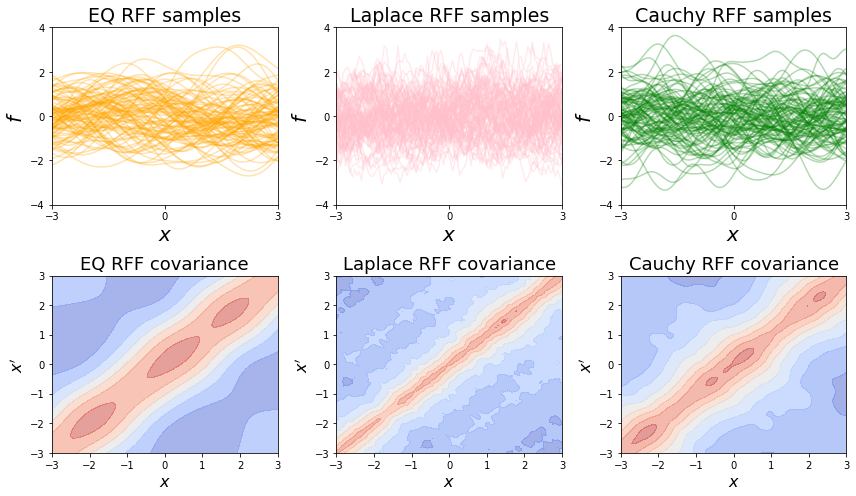

In [5]:
# Titles for sample plots
sample_titles = ['EQ RFF samples',
                 'Laplace RFF samples',
                 'Cauchy RFF samples']

# Titles for kernel plots
kernel_titles = ['EQ RFF covariance',
                 'Laplace RFF covariance',
                 'Cauchy RFF covariance']

colors = ['orange', 'pink', 'green']

# Plot samples and linear model covariances
plt.figure(figsize=(12,7))

for i in range(3):

    functions, features = samples[i]

    # Figure to plot on
    plt.subplot(2, 3, i + 1)

    # Plot sampled functions
    plt.plot(x, functions.T, color=colors[i], alpha=0.3)
    
    # Format plot
    plt.xlim([x.min(), x.max()])
    plt.xlabel("$x$", fontsize=20)
    plt.ylabel("$f$", fontsize=20)
    plt.xticks(np.linspace(-3, 3, 3))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.title(sample_titles[i], fontsize=19)

    plt.subplot(2, 3, i + 4)

    # Plot covariances
    x1, x2 = np.meshgrid(x, x)
    cov = np.einsum('ij, ik -> jk', features[0], features[0])
    plt.contourf(x1, x2, cov, cmap="coolwarm", alpha=0.5)
    
    # Format plot
    plt.xlabel("$x$", fontsize=16)
    plt.ylabel("$x'$", fontsize=16)
    plt.title(kernel_titles[i], fontsize=18)
    
plt.tight_layout()
plt.show()

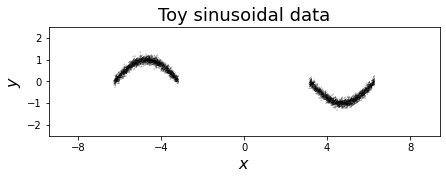

In [6]:
# Number of datapoints to generate
num_data = 4000

# Generate sinusoidal data with a gap in input space
x_data = 4 * np.pi * (np.random.uniform(size=(4 * num_data // 2, 1)) - 0.5)
x_data = np.sort(x_data, axis=0)
x_data = np.concatenate([x_data[:(x_data.shape[0]//4)],
                         x_data[-(x_data.shape[0]//4):]],
                        axis=0)
y_data = np.sin(x_data) + 1e-1 * np.random.normal(size=x_data.shape)
        
# Plot data
plt.figure(figsize=(7, 2))
    
# Plot data points
plt.scatter(x_data, y_data, marker='+', color='k', s=1, alpha=0.2)

# Format plot
plt.title('Toy sinusoidal data', fontsize=18)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
plt.xticks(np.linspace(-8, 8, 5))
plt.yticks(np.linspace(-2, 2, 5))
plt.xlim([1.5 * x_data.min(), 1.5 * x_data.max()])
plt.ylim([-2.5, 2.5])
plt.show()

In [8]:
def rff_posterior(x_data, y_data, x_pred, kernel, lengthscale, coefficient, num_features, noise):
    
    num_data = x_data.shape[0]
    x_full = np.concatenate([x_pred, x_data])
    
    _, features = sample_rff(x=x_full, 
                             kernel=kernel, 
                             lengthscale=lengthscale, 
                             coefficient=coefficient, 
                             num_functions=1, 
                             num_features=num_features)
    features = features[0]
    
    features_pred = features[:, :-num_data]
    features_data = features[:, -num_data:]
    
    iS = np.eye(features_data.shape[0]) + features_data @ features_data.T * noise ** -2

    mean_pred = noise ** -2 * features_pred.T @ np.linalg.solve(iS, features_data @ y_data)[:, 0]
    
    var_pred = np.einsum('fn, fn -> n',
                         features_pred,
                         np.linalg.solve(iS, features_pred))
    
    return mean_pred, var_pred

def covariance(x, x_, kernel, lengthscale, coefficient, noise=None):
    
    diff = x[:, None, :] - x_[None, :, :]
    
    if kernel == 'eq':
        l2 = np.sum((diff / lengthscale) ** 2, axis=2)
        cov = coefficient ** 2 * np.exp(-0.5 * l2)
        
    elif kernel == 'laplace':
        l1 = np.sum(np.abs(diff / lengthscale), axis=2)
        cov = coefficient ** 2 * np.exp(-0.5 * l1)
        
    elif kernel == 'cauchy':
        l2 = np.sum((diff / lengthscale) ** 2, axis=2)
        cov = coefficient ** 2 / (1 + l2)
        
    if noise is not None:
        cov = cov + noise ** 2 * np.eye(cov.shape[0])
    
    return cov


def exact_gp_posterior(x_data, y_data, x_pred, kernel, lengthscale, coefficient, noise):
    
    Kdd = covariance(x_data, x_data, kernel, lengthscale, coefficient, noise)
    Kpd = covariance(x_pred, x_data, kernel, lengthscale, coefficient, None)
    Kpp = covariance(x_pred, x_pred, kernel, lengthscale, coefficient, None)
    
    mean = Kpd @ np.linalg.solve(Kdd, y_data[:, 0])
    var = np.diag(Kpp - Kpd @ np.linalg.solve(Kdd, Kpd.T))
    
    return mean, var

In [ ]:
print('Timing exact GP regression:\n')

%time exact_posteriors = [exact_gp_posterior(x_data,      \
                                             y_data,      \
                                             x_pred,      \
                                             kernel,      \
                                             lengthscale, \
                                             coefficient, \
                                             noise)       \
                          for kernel in kernels]

print('Timing exact approximate RFF regression:\n')

np.random.seed(0)

%time approx_posteriors = [rff_posterior(x_data,       \
                                         y_data,       \
                                         x_pred,       \
                                         kernel,       \
                                         lengthscale,  \
                                         coefficient,  \
                                         num_features, \
                                         noise)        \
                           for kernel in kernels]

In [9]:
# Titles for sample plots
posterior_titles = ['EQ RFF posterior',
                    'Laplace RFF posterior',
                    'Cauchy RFF posterior']

colors = ['orange', 'pink', 'green']

plt.figure(figsize=(13, 3))

for i in range(3):

    approx_mean, approx_var = approx_posteriors[i]
    exact_mean, exact_var = exact_posteriors[i]

    plt.subplot(1, 3, i + 1)
    
    # Plot approximate posterior
    plt.plot(x_pred[:, 0], approx_mean, color='k')
    plt.fill_between(x_pred[:, 0],
                     approx_mean - 2 * approx_var ** 0.5,
                     approx_mean + 2 * approx_var ** 0.5,
                     color=colors[i],
                     alpha=0.3)
    
    # Plot approximate posterior
    plt.plot(x_pred[:, 0], exact_mean, '--', color='k')
    plt.plot(x_pred[:, 0], exact_mean - 2 * exact_var ** 0.5, '--', color='k')
    plt.plot(x_pred[:, 0], exact_mean + 2 * exact_var ** 0.5, '--', color='k')
    
    # Plot data
    plt.scatter(x_data, y_data, marker='+', color='k', s=1, alpha=0.1)
    
    # Format plot
    plt.title(posterior_titles[i], fontsize=18)
    plt.xlabel("$x$", fontsize=16)
    plt.xlim([x_pred.min(), x_pred.max()])
    plt.xticks(np.linspace(-8, 8, 5))
    plt.ylim([-2.5, 2.5])
    
    if i == 0:
        plt.xticks(fontsize=14)
        plt.yticks(np.linspace(-2, 2, 5), fontsize=14)
        plt.ylabel("$y$", fontsize=16)
        
    else:
        plt.yticks([])
    
plt.tight_layout()
plt.show()


NameError: name 'approx_posteriors' is not defined

<Figure size 936x216 with 0 Axes>